# Spanish Translation A/B Test
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.
One reason could be translation. 
The team ran the A/B test where each country would have its one translation written by a local.
The result is surprised that the non-localized translation was doing better.

You are asked to:
1. Confirm that the test is actually negative. That is, it appears that the old version of the
site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted

### Load Data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [84]:
user_table=pd.read_csv('C:/Users/blanc/Desktop/Take Home Challenge/Dataset/Translation_Test/user_table.csv')
test_table=pd.read_csv('C:/Users/blanc/Desktop/Take Home Challenge/Dataset/Translation_Test/test_table.csv')

In [12]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [13]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [146]:
test_table.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


Check the uniqueness of test and user tables

In [155]:
# Check uniqueness
print('Test ID:\t', len(test_table['user_id'].unique()), '\t', len(test_table['user_id'].unique()) == len(test_table))
print('User ID:\t', len(user_table['user_id'].unique()), '\t', len(user_table['user_id'].unique()) == len(user_table))

Test ID:	 453321 	 True
User ID:	 452867 	 True


From the length of two tables, we can find that we have some user_id missing in the user_table.

When joining, we have to be
careful to do not lose the user_ids in the test table, but not in the user table.

In [160]:
data=test_table.merge(user_table,how='left',on='user_id')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [161]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


### Check out the difference between control group and test group

In [27]:
data.groupby('test').mean()

,user_id,conversion,age
test,,,
0,500364.345278,0.055156,27.144850
1,499483.813462,0.043411,27.115236


In [31]:
count_control_rate=len(data[data['test']==0])/len(data)
count_treatment_rate=len(data[data['test']==1])/len(data)
print("percentage of control is", count_control_rate*100)
print("percentage of treatment is", count_treatment_rate*100)

percentage of control is 52.35378157383956
percentage of treatment is 47.646218426160445


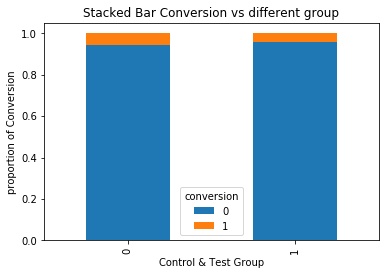

In [39]:
%matplotlib inline
table=pd.crosstab(data.test,data.conversion)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Conversion vs different group')
plt.xlabel('Control & Test Group')
plt.ylabel('proportion of Conversion')
plt.savefig('Conversion proportion for different group')

First, we make the hypothesis that there is no difference between the control and test group.

Ho: Pexp-Pcont=0


For compare two samples:

p=(Xcont+Xexp)/(Ncont+Ntest)

SEpool= sqrt(p*(1-p)*(1/Ncount+1/Ntest))

d=Pexp-Pcont

H0:d=0 where d∼N(0,SEpool)

If d>1.96∗SEpool or d<−1.96∗SEpool then we can reject the null hypothesis and state that our difference represents a statistically significant difference



In [50]:
data[data['conversion']==1].groupby('test').sum()

,user_id,conversion,age
test,,,
0,6568217566,13077,355159
1,4675711952,9367,253870


In [51]:
len(data[data['test']==0])

237093

In [52]:
len(data[data['test']==1])

215774

In [55]:
Xcont=13077
Ncont=237093
Xexp=9367
Ntest=215774

In [66]:
from math import sqrt
P=(Xcont+Xexp)/(Ncont+Ntest)
Pcont=Xcont/Ncont
Pexp=Xexp/Ntest
SEpool=sqrt(P*(1-P)*(1/Ncont+1/Ntest))
d=Pexp-Pcont
d

-0.011744410185782393

In [67]:
-1.96*SEpool

-0.0012656384978395499

As we can see, d< -1.96*SEpool, so it is significant to reject the null hypothesis. There are significant different between control group and test group. since the minimum confidence limit is smaller than 0 and the practical significance level of -0.01, we conclude that it is highly probable that click through probability is lower than 0.01 and is significant. Based on this, one would not launch the new version.

Then we will go deep into the features and find out what causes this result.

### A/B Test


It is true Spain converts much
better than the rest of LatAm countries.

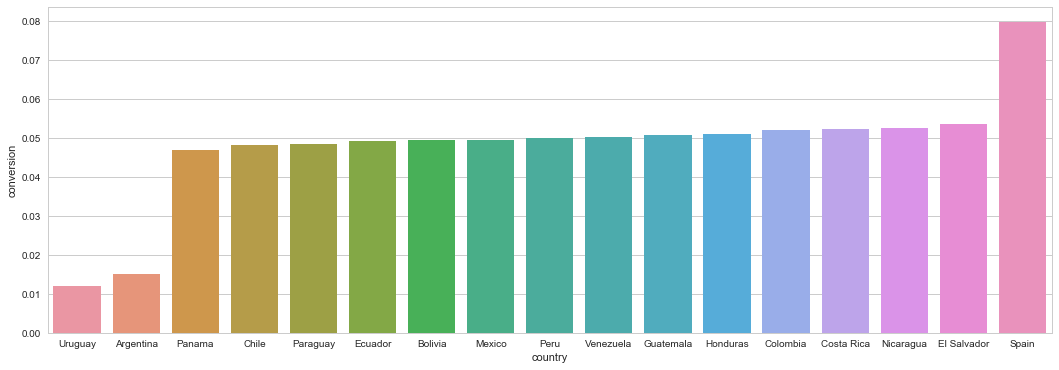

In [176]:
conversion_groupby_country=data[data['test']==0][['conversion','country']].groupby('country').mean()
conversion_groupby_country=conversion_groupby_country.reset_index() ##本来行名是country,列名是conversion.现在多了一列index,行是各个index,列是country和conversion
conversion_groupby_country=conversion_groupby_country.sort_values('conversion')

# Visualization
fig,ax=plt.subplots(figsize=(18, 6))  ##ax:change the figure size
sns.barplot(x='country', y='conversion', data=conversion_groupby_country,ax=ax)
plt.show()

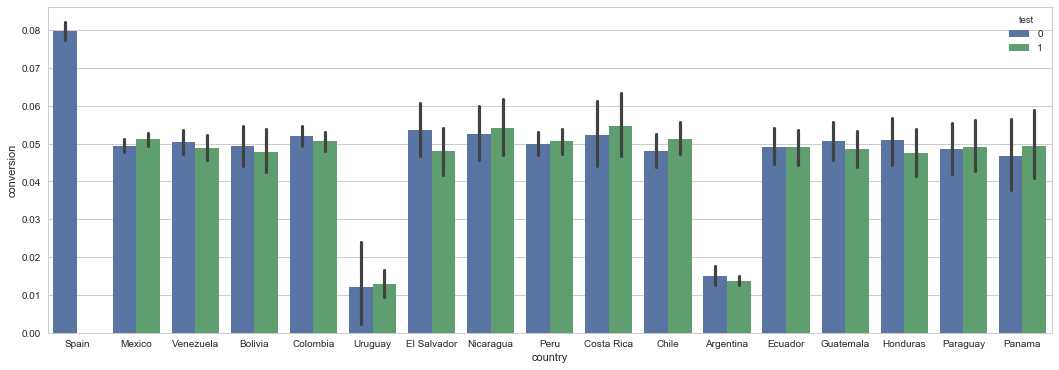

In [178]:
fig,ax=plt.subplots(figsize=(18, 6)) 
sns.barplot(x='country', y='conversion', hue='test',data=data,ax=ax)
plt.show()

### Welch T Test
Test/Control split is ~50/50.


In [182]:
data_test=data.drop(data[data.country=='Spain'].index)
#nothing changed in Spain, so no point in keeping those users

In [183]:
control_group=data_test[(data_test['test']==0)]
test_group=data_test[(data_test['test']==1)]

Test the assumption of normality using the stats.shapiro(). Unfortunately, the output is not labeled. The first value in the tuple is the W test statistic, and the second value is the p-value.

In [185]:
from scipy import stats
a=stats.shapiro(control_group['conversion'])
b=stats.shapiro(test_group['conversion'])
print(a,b)

(0.21902984380722046, 0.0) (0.20420461893081665, 0.0)


Neither of the variables of interest violates the assumption of normality so we can continue with our analysis plan.

In [187]:
stats.ttest_ind(control_group['conversion'], test_group['conversion'], equal_var = False)

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)

The p-value is significant, therefore one can reject the null hypothesis in support of the alternative.

In [193]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}"
          )

welch_ttest(control_group['conversion'], test_group['conversion'])


 Welch's t-test= 7.3939 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 385712.6056


In [189]:
control_group['conversion'].mean()

0.04833042316066309

In [194]:
test_group['conversion'].mean()

0.043424713982118966

in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% ((4.8%-4.3%)/4.8%)
which would be dramatic if it were true. The most likely reason for weird A/B test results are:
1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really random.

In [218]:
control=control_group['conversion'].groupby([control_group['date']]).mean()
test=test_group['conversion'].groupby([test_group['date']]).mean()

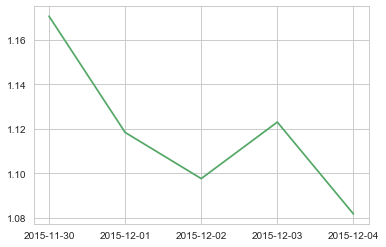

In [217]:
import matplotlib.pyplot as plt
plt.plot(np.sort(control_group['date'].unique()),control/test,'g-')


From the plot, we notice a couple of things:
1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.

Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in
test or in control, this segment had a significantly above/below conversion rate and this affected the overall
results.

In an ideal world, the distribution of people in test and control for each segment should be the same. There
are many ways to check this. One way is to build a decision tree where the variables are the user
dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means
that for given values of that variable you are more likely to end up in test or control. But this should be
impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to
separate the two classes well).

#### Checking the missing value

In [40]:
data.isnull().values.any()

True

In [41]:
data.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

 There more than 50% null values over all data.
I decide to take a look of this column and find out whether this feature is related to conversion rate or not.

In [71]:
data[data['conversion']==1].groupby('ads_channel').mean()

,user_id,conversion,test,age
ads_channel,,,,
Bing,497464.977545,1.0,0.410180,27.214072
Facebook,502496.594922,1.0,0.415176,27.010098
Google,499439.550807,1.0,0.416019,27.113867
Other,499388.701087,1.0,0.396739,26.826087
Yahoo,502452.579405,1.0,0.424220,26.772299


The channel people used to log in site is not much difference in conversion. So we just delete this coulumn.


### Explore Categorical Variables 

In [72]:
data['conversion'].groupby([data['test'], data['ads_channel']]).mean()

test  ads_channel
0     Bing           0.055013
      Facebook       0.056698
      Google         0.054680
      Other          0.050158
      Yahoo          0.055200
1     Bing           0.042102
      Facebook       0.044132
      Google         0.042992
      Other          0.037824
      Yahoo          0.044914
Name: conversion, dtype: float64

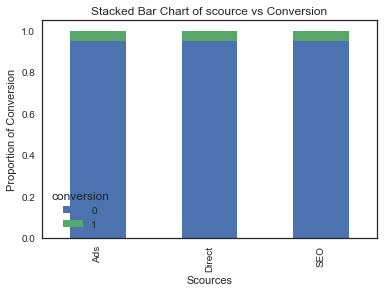

In [75]:
table=pd.crosstab(data.source,data.conversion)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of scource vs Conversion')
plt.xlabel('Scources')
plt.ylabel('Proportion of Conversion')
plt.savefig('scource vs Conversion')

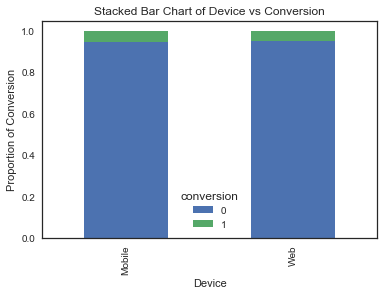

In [78]:
table=pd.crosstab(data.device,data.conversion)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Device vs Conversion')
plt.xlabel('Device')
plt.ylabel('Proportion of Conversion')
plt.savefig('device vs Conversion')

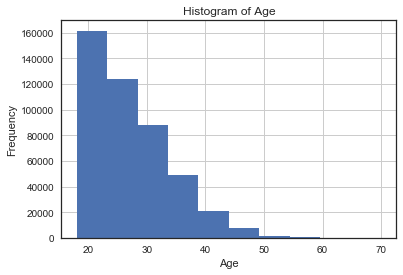

In [76]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the site in this dataset are in the age range of 20-30

In [96]:
data.head()

,user_id,date,source,device,browser_language,browser,conversion,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,IE,1,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,IE,0,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Chrome,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Android_App,0,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,FireFox,0,M,19,Mexico


In [97]:
obj_df = data.select_dtypes(include=['object']).copy()
obj_df.head()

,date,source,device,browser_language,browser,sex,country
0,2015-12-03,Direct,Web,ES,IE,M,Spain
1,2015-12-04,Ads,Web,ES,IE,M,Mexico
2,2015-12-04,Ads,Web,ES,Chrome,M,Spain
3,2015-12-03,Ads,Mobile,Other,Android_App,F,Mexico
4,2015-11-30,Ads,Web,ES,FireFox,M,Mexico


In [98]:
obj_df[obj_df.isnull().any(axis=1)]

,date,source,device,browser_language,browser,sex,country


In [101]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_encoded=data.apply(labelencoder.fit_transform)
data_encoded.head()

,user_id,date,source,device,browser_language,browser,conversion,sex,age,country
0,142925,3,1,1,1,3,1,1,14,14
1,225446,4,0,1,1,3,0,1,3,9
2,384309,4,0,1,1,1,0,1,16,14
3,131463,3,0,0,2,0,0,0,4,9
4,248304,0,0,1,1,2,0,1,1,9


In [103]:
Y=data_encoded[['conversion']]

In [105]:
X=data_encoded.loc[:,data_encoded.columns!='conversion']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, Y, test_size=0.3, random_state=42)

In [117]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [132]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))




name                   score
user_id           0.599365
age               0.162492
country           0.076007
date              0.0528182
browser           0.0340244
source            0.0308714
sex               0.0206166
browser_language  0.0175022
device            0.00630317


From the features, we can see that countries is the most important feature for conversion.
Now, let us check for each country:

In [224]:
countries = [name for name in data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = stats.ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Spain                       nan         0.07972        nan
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091  

After we control for country, the test clearly appears non significant. Not a great success given that the
goal was to improve conversion rate, but at least we know that a localized translation didn’t make things
worse!

In [235]:
import copy

def combine(l, n): 
    answers = []
    one = [0] * n 
    def next_c(li = 0, ni = 0): 
        if ni == n:
            answers.append(copy.copy(one))
            return
        for lj in range(li, len(l)):
            one[ni] = l[lj]
            next_c(lj + 1, ni + 1)
    next_c()
    return answers

print(combine([1, 2, 3, 4, 5], 2))

[[1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]


In [236]:
import itertools
nums = itertools.permutations([1,2,3,4,5])
for x in  nums:
    print(x)

(1, 2, 3, 4, 5)
(1, 2, 3, 5, 4)
(1, 2, 4, 3, 5)
(1, 2, 4, 5, 3)
(1, 2, 5, 3, 4)
(1, 2, 5, 4, 3)
(1, 3, 2, 4, 5)
(1, 3, 2, 5, 4)
(1, 3, 4, 2, 5)
(1, 3, 4, 5, 2)
(1, 3, 5, 2, 4)
(1, 3, 5, 4, 2)
(1, 4, 2, 3, 5)
(1, 4, 2, 5, 3)
(1, 4, 3, 2, 5)
(1, 4, 3, 5, 2)
(1, 4, 5, 2, 3)
(1, 4, 5, 3, 2)
(1, 5, 2, 3, 4)
(1, 5, 2, 4, 3)
(1, 5, 3, 2, 4)
(1, 5, 3, 4, 2)
(1, 5, 4, 2, 3)
(1, 5, 4, 3, 2)
(2, 1, 3, 4, 5)
(2, 1, 3, 5, 4)
(2, 1, 4, 3, 5)
(2, 1, 4, 5, 3)
(2, 1, 5, 3, 4)
(2, 1, 5, 4, 3)
(2, 3, 1, 4, 5)
(2, 3, 1, 5, 4)
(2, 3, 4, 1, 5)
(2, 3, 4, 5, 1)
(2, 3, 5, 1, 4)
(2, 3, 5, 4, 1)
(2, 4, 1, 3, 5)
(2, 4, 1, 5, 3)
(2, 4, 3, 1, 5)
(2, 4, 3, 5, 1)
(2, 4, 5, 1, 3)
(2, 4, 5, 3, 1)
(2, 5, 1, 3, 4)
(2, 5, 1, 4, 3)
(2, 5, 3, 1, 4)
(2, 5, 3, 4, 1)
(2, 5, 4, 1, 3)
(2, 5, 4, 3, 1)
(3, 1, 2, 4, 5)
(3, 1, 2, 5, 4)
(3, 1, 4, 2, 5)
(3, 1, 4, 5, 2)
(3, 1, 5, 2, 4)
(3, 1, 5, 4, 2)
(3, 2, 1, 4, 5)
(3, 2, 1, 5, 4)
(3, 2, 4, 1, 5)
(3, 2, 4, 5, 1)
(3, 2, 5, 1, 4)
(3, 2, 5, 4, 1)
(3, 4, 1, 2, 5)
(3, 4, 1, 5, 2)
(3, 4, 2